## Data Exploration

In [12]:

s3_data ="s3://aegovan-data/human_output/human_keyinteractions.json"
s3_annotations ="s3://aegovan-data/input_data_pubtator_annotated.txt"
human_idmapping_dat = "/Users/aeg/Downloads/HUMAN_9606_idmapping.dat"

In [ ]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [28]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

NameError: name 'download_single_file' is not defined

In [ ]:
download_single_file(s3_annotations, annotations_file)

In [29]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [8]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

### Sneak preview of the data

In [30]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isNegative"] = data.isNegative.isin(['true', '1', 'True'])

In [31]:
data.head(n=3)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2503513,phosphorylation,False,"[{'uniprotid': 'P43405', 'alias': [['ksyk_human'], ['Tyrosine-protein kinase SYK'], ['SYK'], ['Spleen tyrosine kinase'], ['p72-Syk']]}, {'uniprotid': 'Q9BSZ5', 'alias': [['asc_human'], ['Apoptosis-associated speck-like protein containing a CARD'], ['PYD and CARD domain-containing protein'], ['Target of methylation-induced silencing 1'], ['Caspase recruitment domain-containing protein 5'], ['ASC'], ['CARD5'], ['TMS1'], ['PYCARD']]}]",25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
10,1796163,phosphorylation,False,"[{'uniprotid': 'Q8WUB1', 'alias': [['kc1g2_human'], ['Casein kinase I isoform gamma-2'], ['CK1G2'], ['CSNK1G2']]}, {'uniprotid': 'Q6ZS50', 'alias': [['lrrk2_human'], ['Leucine-rich repeat serine/threonine-protein kinase 2'], ['LRRK2'], ['PARK8'], ['Dardarin']]}]",25500533,None,"LRRK2, a gene relevant to Parkinson's disease,

### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

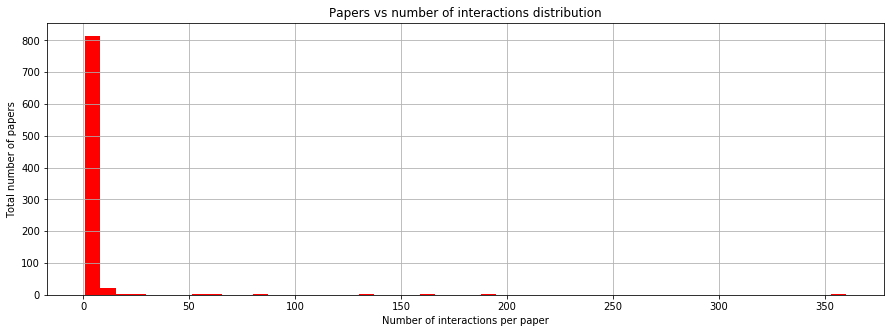

In [33]:
import matplotlib.pyplot as plt

data.pubmedId.value_counts().hist (bins=50, figsize=(15,5), color = 'red')
plt.title('Papers vs number of interactions distribution')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

In [ ]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of interactions')

plt.show()

### Filter out interactions from paper with more than 15 interactions

In [ ]:
pubmed_interaction_count = data.pubmedId.value_counts().to_frame().rename(columns={"pubmedId":"interactionCountPerPubmed"})


In [ ]:
interactions_count= pd.DataFrame()
data["lessThanThreshold"] = data.apply(lambda r: r["pubmedId"] in  pubmed_interaction_count.query('interactionCountPerPubmed <= 15').index , 1)


data.lessThanThreshold.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has more than 15 interactions')
plt.show()

In [ ]:
data = data.query("lessThanThreshold == 1")

In [ ]:
print("Total number of records after filter: {}".format(data.shape[0]))

### Interaction Types distribution

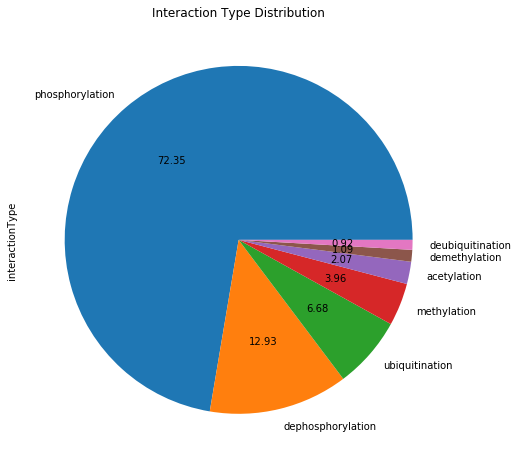

In [55]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [ ]:
data.interactionType.value_counts().to_frame()

### Distinct interaction types per paper

In [ ]:
distinct_no_papers = data['pubmedId'].nunique()
data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100)
plt.title("Number of unique interactions per paper")
plt.xlabel('Number of interactions')
plt.ylabel('Number of papers (total is {})'.format(distinct_no_papers))
plt.show()

### Postive vs Negative Relationships

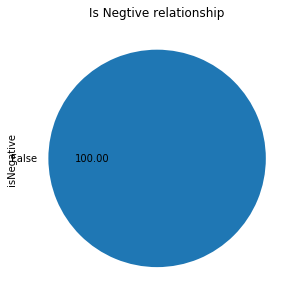

In [35]:
data.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Negtive relationship')
plt.show()

### Number of participants per interaction

In [ ]:
data["participants"].apply(lambda x: len(x)).hist (bins=50, figsize=(5,5), color = 'green')
plt.title("Participants count per interaction")
plt.show()

### Explore if the abstract contains the trigger word

In [ ]:
data["hasTriggerWord"] = data.apply(lambda r: r["interactionType"].lower() in r["pubmedabstract"].lower() , 1)

In [ ]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [ ]:
fig, ax = plt.subplots( 7,1, figsize=(45,30))
data.groupby(['hasTriggerWord', 'interactionType']).size().unstack().plot(kind='pie', subplots='True',autopct='%.2f', ax=ax)
plt.show()

### Explore how many of the entity alias are mentioned in the abstract

In [ ]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

In [ ]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

In [ ]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [ ]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=10)


In [ ]:
data.head(n=10)

### Data Transformation

In [31]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(data)


In [37]:
data_transformed.head(n=2)

,interactionId,interactionType,isNegative,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
0,2503510,phosphorylation,False,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."
1,2503513,phosphorylation,False,"[[ksyk_human], [Tyrosine-protein kinase SYK], [SYK], [Spleen tyrosine kinase], [p72-Syk]]",P43405,"[[asc_human], [Apoptosis-associated speck-like protein containing a CARD], [PYD and CARD domain-containing protein], [Target of methylation-induced silencing 1], [Caspase recruitment domain-containing protein 5], [ASC], [CARD5], [TMS1], [PYCARD]]",Q9BSZ5,25605870,None,"NLRP3 is the most crucial member of the NLR family, as it detects the existence of pathogen invasion and self-derived molecules associated with cellular damage. Several studies have reported that excessive NLRP3 inflammasome-mediated caspase-1 activation is a key factor in the development of diseases. Recent studies have reported that Syk is involved in pathogen-induced NLRP3 inflammasome activation; however, the detailed mechanism linking Syk to NLRP3 inflammasome remains unclear. In this study, we showed that Syk mediates NLRP3 stimuli-induced processing of procaspase-1 and the consequent activation of caspase-1. Moreover, the kinase activity of Syk is required to potentiate caspase-1 activation in a reconstituted NLRP3 inflammasome system in HEK293T cells. The adaptor protein ASC bridges NLRP3 with the effector protein caspase-1. Herein, we find that Syk can associate directly with ASC and NLRP3 by its kinase domain but interact indirectly with procaspase-1. Syk can phosphorylate ASC at Y146 and Y187 residues, and the phosphorylation of both residues is critical to enhance ASC oligomerization and the recruitment of procaspase-1. Together, our results reveal a new molecular pathway through which Syk promotes NLRP3 inflammasome formation, resulting from the phosphorylation of ASC. Thus, the control of Syk activity might be effective to modulate NLRP3 inflammasome activation and treat NLRP3-related immune diseases."


In [38]:
data_transformed.shape

(5510, 10)

Okay.. looks like it is only a case of the names of the participants not matching the names of the alias used in the abstract.. 

### Data Engineering

#### Add more negative samples

In [39]:

def generate_negative_old(data):
    import uuid
    unique_pubmeds = data["pubmedId"].unique()
    data_fake = pd.DataFrame(columns=data.columns)

    num_fake_records = int( .50 * len(data))
    #TODO: Randomise this, biased via
    for u in unique_pubmeds:
        fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
        fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
        fake_records.loc[:,"isNegative"] = 'True' 
        ## Copy of the pubmeid abtract and the title from a id
        fake_records.loc[:,"pubmedId"] = u
        fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
        fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


        data_fake = data_fake.append(fake_records, ignore_index=True)
        if len(data_fake) > num_fake_records:
            break
            
    return data_fake
  
    

In [32]:

def generate_negative(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
        result = negative_samples_generator.transform(result)

        return result

Remove records where the alias is null

In [33]:
data_filtered = data_transformed[data_transformed.participant1Alias.notnull()]
data_filtered = data_filtered[data_filtered.participant2Alias.notnull()]

In [34]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_filtered, test_size=.2,
                                                        random_state=777)

train, val = train_test_split(train, test_size=.2,
                                                        random_state=777)

In [35]:
train = generate_negative(train, annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))


The total number of train records including fake records 10730


In [36]:


test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of test records including fake records 4683
The total number of val records including fake records 3879


In [45]:
train.sort_values(by=["pubmedId"]).query("interactionType != 'phosphorylation'").head(n=10)

,interactionId,interactionType,isNegative,participant1Alias,participant1Id,participant2Alias,participant2Id,pubmedId,pubmedTitle,pubmedabstract
2534,1215357_fdaba8dd-7f90-48ce-b207-5c3c6ec55235_fake_annot,methylation,True,"[[ptprr_mouse], [Receptor-type tyrosine-protein phosphatase R], [Ptprr], [Ptp13], [Phosphotyrosine phosphatase 13], [Protein-tyrosine-phosphatase SL]]",Q9QUH9,"[[mk03_human], [Mitogen-activated protein kinase 3], [ERT2], [MAP kinase isoform p44], [Microtubule-associated protein 2 kinase], [Extracellular signal-regulated kinase 1], [Insulin-stimulated MAP2 kinase], [p44-ERK1], [MAPK3], [ERK1], [PRKM3]]",Q8NHX1,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF), nerve growth factor (NGF), and constitutively active MEK1, a mutant MAPK kinase. In contrast, catalytically inactive and ERK-binding-deficient mutants revealed little inhibition on the ERK cascade. These results indicate that PTPBR7 suppresses MAPK directly in vivo."
7163,1215357_d64126c7-079c-45d9-9fbe-e79837f742be_fake_annot,dephosphorylation,True,"[nerve growth factor, NGF]",P01138,"[extracellular signal-regulated kinase, ERK2, ERK]",Q499G7,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF), nerve growth factor (NGF), and constitutively active MEK1, a mutant MAPK kinase. In contrast, catalytically inactive and ERK-binding-deficient mutants revealed little inhibition on the ERK cascade. These results indicate that PTPBR7 suppresses MAPK directly in vivo."
7164,1215357_92b62e69-00c4-4861-87f6-6488b927159e_fake_annot,dephosphorylation,True,"[extracellular signal-regulated kinase, ERK2, ERK]",Q499G7,[ERK1],Q9BWJ1,10066421,None,"Mitogen-activated protein kinase (MAPK) is inactivated through dephosphorylation of tyrosyl and threonyl regulatory sites. In yeast, both dual-specificity and tyrosine-specific phosphatases are involved in dephosphorylation. In mammals, however, no tyrosine-specific phosphatase has been identified molecularly to dephosphorylate MAPK in vivo. Recently, we and others have cloned a murine tyrosine-specific phosphatase, PTPBR7/PTP-SL, which is expressed predominantly in the brain. Here we report inactivation of the extracellular signal-regulated kinase (ERK) family MAPK by PTPBR7. PTPBR7 made complexes with ERK1/ERK2 in vivo and dephosphorylated ERK1 in vitro. When overexpressed in mammalian cells, wild-type PTPBR7 suppressed the phosphorylation and activation of ERK by epidermal growth factor (EGF), nerve growth factor (

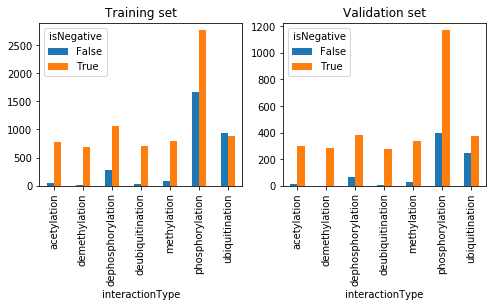

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 1,2, figsize=(8,3))

#fig, ax = plt.subplots( 7,1, figsize=(45,30))
train.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[0])
ax[0].set_title( "Training set")


val.groupby(['interactionType', 'isNegative']).size().unstack().plot.bar(ax=ax[1])
ax[1].set_title( "Validation set")


plt.savefig("NegativeSample.svg",bbox_inches = "tight")
plt.show()

In [24]:
val.groupby(['isNegative', 'interactionType']).size()

isNegative  interactionType  
false       acetylation           14
            demethylation          1
            dephosphorylation     67
            deubiquitination       8
            methylation           30
            phosphorylation      396
            ubiquitination       249
dtype: int64

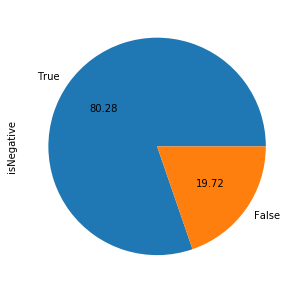

In [48]:
import matplotlib.pyplot as plt
val.isNegative.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))

In [ ]:
train.to_json("train.json")
test.to_json("test.json")
val.to_json("val.json")

### Train val split such that the pubmedid do not overladp

In [49]:
from sklearn.model_selection import train_test_split
trainpubmed, testpubmed = train_test_split(data_filtered.pubmedId.unique(), test_size=.2,
                                                        random_state=777)

trainpubmed, valpubmed = train_test_split(trainpubmed, test_size=.2,
                                                        random_state=777)

In [19]:
print("Unique pubmeds in train {}, test {} and val {}".format(len(trainpubmed), len(testpubmed),len(valpubmed)))

Unique pubmeds in train 531, test 166 and val 133


In [50]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]



In [51]:

train = generate_negative(train,  annotations_file)
print("The total number of train records including fake records {}".format(train.shape[0]))



test = generate_negative(test,  annotations_file)
print("The total number of test records including fake records {}".format(test.shape[0]))


val = generate_negative(val, annotations_file)
print("The total number of val records including fake records {}".format(val.shape[0]))

The total number of train records including fake records 9214
The total number of test records including fake records 2913
The total number of val records including fake records 1692


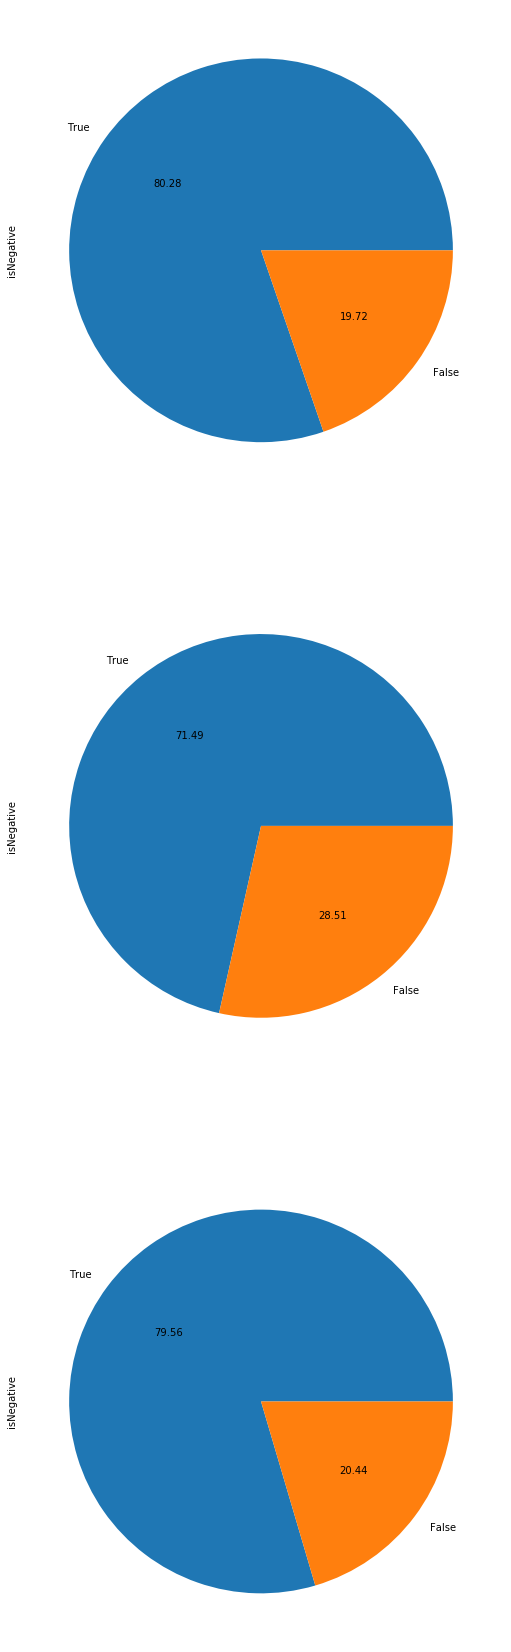

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots( 3,1, figsize=(50,30))
train.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[1])


val.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[0])

test.isNegative.value_counts().plot.pie(autopct='%.2f',ax=ax[2])

In [53]:
train.to_json("train_unique_pub.json")
test.to_json("test_unique_pub.json")
val.to_json("val_unique_pub.json")

In [ ]:
train.head(n=3)